# Optimal HDBSCAN* Leaves

In [1]:
import numpy as np
from fast_hdbscan import HDBSCAN

import requests
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize": (8, 8)})

In [2]:
data_request = requests.get(
    "https://github.com/scikit-learn-contrib/hdbscan/blob/master/notebooks/clusterable_data.npy?raw=true"
)
data = np.load(BytesIO(data_request.content))

It is possible to compute an exact merge-tree for leaf-clusters with a moving
minimum cluster size threshold. The idea is equivalent to computing a single
linkage hierarchy from a minimum spanning tree. The procedure below iterates
over the condensed tree leaves. In each iteration a leave is processed. Their
minimum-cluster-size-deaths are recorded and the remaining condensed tree is
inspected to determine whether the parent segment has become a leaf. The process
continuous until a single leaf remains and computes the condensed hierarchy only
once! 

In [3]:
import numba
from heapq import heappush, heappop
from collections import namedtuple
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    cluster_tree_leaves,
    CondensedTree,
)


# Priority queue item
LeafItem = namedtuple("LeafItem", ["death", "id"])
# Additional attributes stored outside the queue
LeafAttrs = namedtuple("LeafAttrs", ["birth", "idx"])
# Output information
LeafInfo = namedtuple("LeafInfo", ["birth", "death"])


@numba.njit()
def copy_condensed_tree(condensed_tree):
    """Copy a CondensedTree object."""
    return CondensedTree(
        condensed_tree.parent.copy(),
        condensed_tree.child.copy(),
        condensed_tree.lambda_val.copy(),
        condensed_tree.child_size.copy(),
    )


@numba.njit()
def replace_value(array, target, value):
    """Inplace update of the parent value for rows with sibling as parent."""
    for idx, row in enumerate(array):
        if row == target:
            array[idx] = value


# @numba.njit()
def min_cluster_size_barcode(condensed_tree, n_points, min_size):
    """Lists cluster tree leaves with their birth and death minimum cluster sizes."""
    # Define structures
    leaves = {np.int64(0): LeafInfo(np.int32(0), np.int32(0)) for _ in range(0)}
    queue = [LeafItem(np.int32(0), np.int64(0)) for _ in range(0)]
    enqueued = {np.int64(0): LeafAttrs(np.int32(0), np.int64(0)) for _ in range(0)}

    # Enqueue initial leaves
    cluster_tree = copy_condensed_tree(cluster_tree_from_condensed_tree(condensed_tree))
    for leaf in cluster_tree_leaves(cluster_tree, n_points):
        # Get the min cluster size at which these leaves die
        leaf_idx = np.searchsorted(cluster_tree.child, leaf)
        leaf_size = cluster_tree.child_size[leaf_idx]
        heappush(queue, LeafItem(np.int32(leaf_size + 1), leaf))
        enqueued[leaf] = LeafAttrs(np.int32(min_size), leaf_idx)

    # Process detected leaves
    root = condensed_tree.parent[0]
    while queue:
        # Skip leaves already processed as sibling
        death, leaf = heappop(queue)
        if leaf not in enqueued or leaf == root:
            continue
        birth, leaf_idx = enqueued.pop(leaf)
        leaves[leaf] = LeafInfo(birth, death)

        # Extract leaf information
        #   Odd/even leaf indices use previous/next row as sibling
        sibling_idx = leaf_idx + (((leaf_idx % 2) * -2) + 1)
        sibling = cluster_tree.child[sibling_idx]
        parent = cluster_tree.parent[leaf_idx]

        # Detect if parent becomes a leaf (i.e., sibling is also a leaf)
        if sibling in enqueued:
            # Also process the sibling's info
            sibling_birth, _ = enqueued.pop(sibling)
            leaves[sibling] = LeafInfo(sibling_birth, death)

            # Enqueue the parent
            parent_idx = np.searchsorted(cluster_tree.child, parent)
            parent_size = cluster_tree.child_size[parent_idx]
            heappush(queue, LeafItem(np.int32(parent_size + 1), parent))
            enqueued[parent] = LeafAttrs(death, parent_idx)
        else:
            replace_value(cluster_tree.parent, sibling, parent)

    birth, _ = enqueued.pop(root)
    leaves[root] = LeafInfo(birth, np.int32(n_points + 1))
    return leaves

In [4]:
from fast_hdbscan.hdbscan import (
    compute_minimum_spanning_tree,
    mst_to_linkage_tree,
    condense_tree,
)

# Compute initial condensed tree
min_cluster_size = 5
n_points = data.shape[0]
minimum_spanning_tree, _, _ = compute_minimum_spanning_tree(
    data, min_samples=min_cluster_size
)
sorted_mst = minimum_spanning_tree[
    np.lexsort(
        (
            minimum_spanning_tree.T[1],
            minimum_spanning_tree.T[0],
            minimum_spanning_tree.T[2],
        )
    )
]
linkage_tree = mst_to_linkage_tree(sorted_mst)
condensed_tree = condense_tree(linkage_tree, min_cluster_size=min_cluster_size)

# Extract leaves-tree from the condensed tree
leaves = min_cluster_size_barcode(condensed_tree, data.shape[0], min_cluster_size)

### Quality measures

Computing the number of noise points at each minimum cluster size is trivial.

In [5]:
# @numba.njit()
def num_points_in_clusters(leaves, root):
    max_birth = leaves[root].birth
    clustered_points = np.zeros(max_birth + 1)
    for birth, death in leaves.values():
        clustered_points[birth:min(max_birth, death)] += death - 1
    return clustered_points

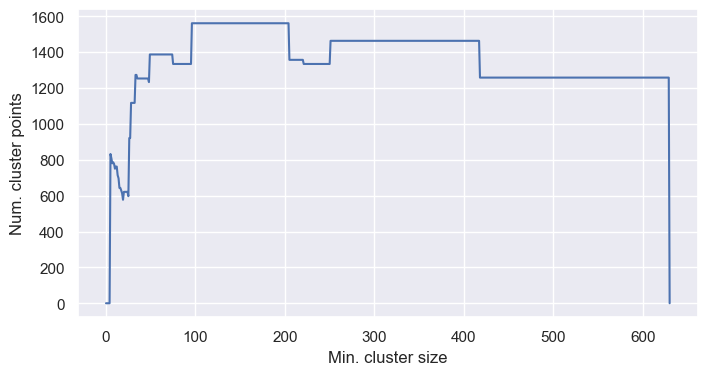

In [6]:
# List the number of points in each leaf birth and death
clustered_points = num_points_in_clusters(leaves, condensed_tree.parent[0])

plt.figure(figsize=(8, 4))
plt.plot(clustered_points)
plt.xlabel("Min. cluster size")
plt.ylabel("Num. cluster points")
plt.show()

Computing condensed-tree stability for leaf-clusters at the different minimum
cluster sizes:

- only compute persistence between min_cluster_size birth and death.
- consider points in all cluster_tree child segments.
- compute persistence as $\lambda_{enter} - \lambda_{death}$
- compute stability as the sum of persistences for the points in a segment
  - the initial min cluster size points enter at the density at which the
    segment meets the minimum cluster size threshold!
  - other points enter at their density in the condensed tree.
- aggregate stabilities over all leaf-clusters.

In [7]:
from fast_hdbscan.cluster_trees import mask_condensed_tree

# @numba.njit()
def bf_children(cluster_tree, segment_id):
    """Extracts points in the condensed tree below the leaf_id segment."""
    to_process = [segment_id]
    result = [np.int64(0) for _ in range(0)]

    while len(to_process) > 0:
        result.extend(to_process)
        to_process = list(cluster_tree.child[
            np.isin(cluster_tree.parent, to_process, assume_unique=True)
        ])
    return result


# @numba.njit()
def compute_leaf_stability(leaf_id, leaf, cluster_tree, points_tree,):
    """Computes the lambda persistence curve of a leaf-cluster tree segment."""
    # Extract points within the leaf-cluster
    min_size = leaf.birth
    max_size = leaf.death
    if leaf_id != cluster_tree.parent[0]:
        segment_ids = bf_children(cluster_tree, leaf_id)
        segment_points = mask_condensed_tree(points_tree, np.isin(points_tree.parent, segment_ids))
        lambda_death = cluster_tree.lambda_val[np.searchsorted(cluster_tree.child, leaf_id)]
    else:
        segment_points = points_tree
        lambda_death = 0

    # Find lambda values for points entering the cluster within its size range.
    # The partition lets us sort just the points in the size range.
    leaf_size = segment_points.parent.shape[0]
    indices = [leaf_size - max_size + 1, leaf_size - min_size + 1]
    lambdas = np.partition(segment_points.lambda_val, indices)
    lambda_births = np.sort(lambdas[indices[0] : indices[1]])[::-1]

    # Create stability array
    #   stability = min_size * (birth - death) + sum(enter - death)
    birth_size = np.arange(min_size, max_size)
    persistences = lambda_births - lambda_death
    stability = (birth_size - 1) * persistences + np.cumsum(persistences[::-1])[::-1]
    return stability


# @numba.njit()
def compute_stabilities(condensed_tree, leaves):
    mask = condensed_tree.child_size > 1
    cluster_tree = mask_condensed_tree(condensed_tree, mask)
    points_tree = mask_condensed_tree(condensed_tree, ~mask)
    stabilities = {
        leaf_id: compute_leaf_stability(
            leaf_id, leaf, cluster_tree, points_tree
        ) for leaf_id, leaf in leaves.items()
    }

    max_birth = leaves[cluster_tree.parent[0]].birth
    total_stability = np.zeros(max_birth + 1)
    for leaf, attrs in leaves.items():
        min_size = attrs.birth
        max_size = min(max_birth, attrs.death)
        
        total_stability[min_size:max_size] += stabilities[leaf][:max_size-min_size]

    return total_stability, stabilities

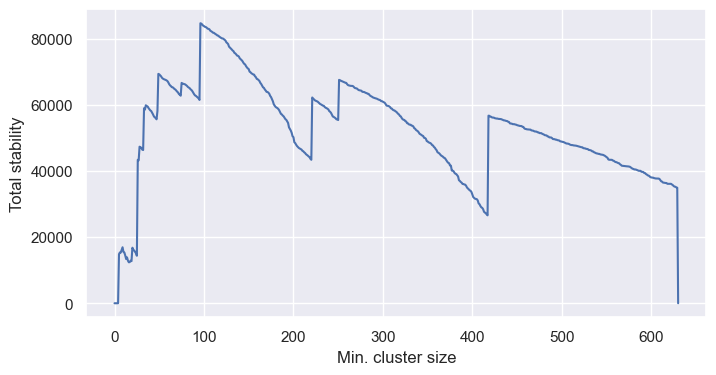

In [8]:
total_stability, stabilities = compute_stabilities(condensed_tree, leaves)

fig = plt.figure(figsize=(8, 4))
plt.plot(total_stability)
plt.ylabel("Total stability")
plt.xlabel("Min. cluster size")
plt.show()

### Straight min_cluster_size cuts

A straight min_cluster_size cut seems most appropriate to select clusters. The
clusters selected by such a cut can vary in density and do not have to form a
straight cut in the condensed tree.

Maximizing the total stability works and relates to minimizing the number of
noise points. The total stability at a particular minimum cluster size is a sum
of density persistences over all points in the clusters at that threshold. That
signal contains the noise point trace. In addition, the stability of each
leaf-cluster is always largest at its birth. I think that means that the total
stability has a maximum when the number of noise points is minimal. Maybe there
are weird cases where it does not hold?

The optimal minimum cluster size has the lowest number of noise points or
highest total stability (equivalent in this case), finding the same labelling as
`LayerClustering`:

In [9]:
from fast_hdbscan.cluster_trees import (
    get_cluster_label_vector,
    get_point_membership_strength_vector,
)


# @numba.njit()
def optimal_clustering(condensed_tree, leaves, total_stability, n_points):
    best_size = np.argmax(total_stability)
    select_leaves = [
        leaf_id
        for leaf_id, attrs in leaves.items()
        if attrs.birth <= best_size and attrs.death > best_size
    ]

    labels = get_cluster_label_vector(
        condensed_tree, select_leaves, cluster_selection_epsilon=0.0, n_samples=n_points
    )
    probs = get_point_membership_strength_vector(condensed_tree, select_leaves, labels)
    return labels, probs, best_size

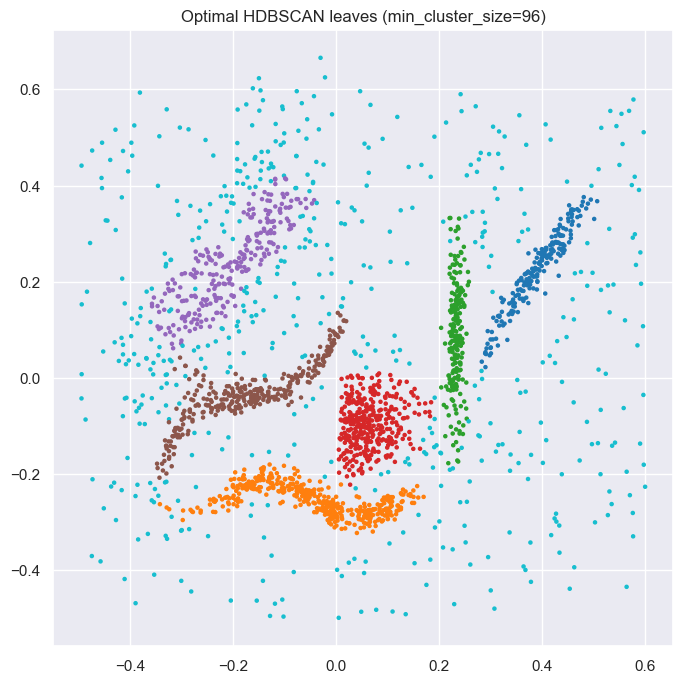

In [10]:
labels, probs, best_size = optimal_clustering(
    condensed_tree, leaves, total_stability, data.shape[0]
)
plt.scatter(*data.T, c=labels % 10, s=5, cmap="tab10", vmax=9, vmin=0)
plt.title(f"Optimal HDBSCAN leaves (min_cluster_size={best_size})")
plt.show()

### Leaf-cluster tree plot

Plotting the leaf-cluster tree with `plt.pcolormesh`. Icicle widths indicate the
cluster's stability at that minimum cluster size. Icicle color indicates the
total stability over all clusters at that minimum cluster size.

In [13]:
import warnings
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap


def find_leaf_cluster_parents(condensed_tree, leaves):
    """Finds first condensed tree ancestor that is a leaf-cluster"""
    parents = {}
    root = condensed_tree["parent"][0]
    cluster_tree = condensed_tree[condensed_tree["child_size"] > 1]
    for leaf_id in leaves.keys():
        if leaf_id == root:
            continue

        current = leaf_id
        while current == leaf_id or current not in leaves:
            current = cluster_tree["parent"][
                np.searchsorted(cluster_tree["child"], current)
            ]
        parents[leaf_id] = current
    return parents


def compute_x_coords(parents, root):
    """Compute x-coordinates for the leaf clusters."""
    # Convert to directed graph
    children = dict()
    for leaf_id, parent in parents.items():
        parent = parents[leaf_id]
        if parent not in children:
            children[parent] = []
        children[parent].append(leaf_id)

    # List x-coordinates
    return {leaf: i for i, leaf in enumerate(df_leaf_order(children, root))}


def df_leaf_order(children, id):
    """Depth-first traversal to order the leaf clusters."""
    order = [id]
    if id in children:
        for child in sorted(
            children[id], key=lambda x: leaves[x].death, reverse=True
        ):
            order += df_leaf_order(children, child)
    return order


class LeafClusterTree:
    def __init__(self, labels, condensed_tree, leaves, total_stability, stabilities):
        self.labels = labels
        self.condensed_tree = condensed_tree
        self.root = condensed_tree["parent"][0]
        self.leaves = leaves
        self.parents = find_leaf_cluster_parents(condensed_tree, leaves)
        self.stabilities = stabilities
        self.total_stability = total_stability
        self.max_stability = max(stab.max() for stab in stabilities.values())
        self.max_total_stability = total_stability.max()

    def as_pandas(self):
        import pandas as pd

        df = pd.DataFrame.from_dict(self.leaves, orient="index")
        df["parent"] = df.index.map(self.parents)
        df["stability"] = df.index.map(self.stabilities)
        return df

    def _select_clusters(self):
        cluster_tree = self.condensed_tree[self.condensed_tree["child_size"] > 1]
        points_tree = self.condensed_tree[self.condensed_tree["child_size"] == 1]
        
        # Find lowest cluster segment id for each cluster label
        segments = points_tree['parent']
        labels = self.labels[points_tree['child']]
        order = np.argsort(labels)
        groups = np.split(segments[order], np.flatnonzero(np.diff(labels[order]) != 0) + 1)
        selected_clusters = [
            groups[label].min() for label in range(int(labels[order[0]] == -1), len(groups))
        ]
        
        # Find first condensed tree ancestor that is a leaf-cluster
        for label, leaf_id in enumerate(selected_clusters):
            while leaf_id not in self.leaves:
                leaf_id = cluster_tree["parent"][np.searchsorted(cluster_tree["child"], leaf_id)]
            selected_clusters[label] = leaf_id

        return selected_clusters

    def plot(
        self,
        inf_padding=0.1,
        min_width=0.05,
        max_width=4,
        cmap="viridis",
        colorbar=True,
        colorbar_kws=None,
        death_line_kws=None,
        connect_line_kws=None,
        indicator_radius=30,
        indicator_offset=8,
        selection_palette=None,
    ):
        if colorbar_kws is None:
            colorbar_kws = dict()
        max_width = (max_width - min_width) / 2
        max_birth = self.leaves[self.root].birth
        inf_value = round((1 + inf_padding) * max_birth)
        x_coords = compute_x_coords(self.parents, self.root)

        _death_line_kws = dict(linestyle=":", color="black", linewidth=0.5)
        if death_line_kws is not None:
            _death_line_kws.update(death_line_kws)
        plt.gca().add_collection(
            LineCollection(
                [
                    [
                        (x_coords[leaf_id], self.leaves[leaf_id].death),
                        (x_coords[leaf_id], self.leaves[parent].birth),
                    ]
                    for leaf_id, parent in self.parents.items()
                ],
                **_death_line_kws
            )
        )

        _connect_line_kws = dict(linestyle="-", color="black", linewidth=0.5)
        if connect_line_kws is not None:
            _connect_line_kws.update(connect_line_kws)
        plt.gca().add_collection(
            LineCollection(
                [
                    [
                        (x_coords[leaf_id], self.leaves[parent].birth),
                        (x_coords[parent], self.leaves[parent].birth),
                    ]
                    for leaf_id, parent in self.parents.items()
                ],
                **_connect_line_kws
            )
        )

        for leaf_id, leaf in self.leaves.items():
            stability = self.stabilities[leaf_id]
            min_size = leaf.birth
            max_size = min(leaf.death, inf_value)

            # Y dimension:
            sizes = np.arange(min_size, max_size)
            # X dimension:
            stability = stability[: max_size - min_size]
            xs = x_coords[leaf_id] + np.asarray([[-min_width / 2], [min_width / 2]])
            widths = xs + stability / self.max_stability * max_width * np.array([[-1], [1]])
            # Color dimensions:
            total_stability = self.total_stability[min_size:max_size]
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                bar = plt.pcolormesh(
                    widths,
                    np.broadcast_to(sizes, (2, len(sizes))),
                    np.broadcast_to(total_stability, (2, len(sizes))),
                    vmin=0,
                    vmax=self.max_total_stability,
                    edgecolors="none",
                    linewidth=0,
                    cmap=cmap,
                )

        if indicator_radius > 0:
            if selection_palette is None:
                selection_palette = plt.cm.tab10.colors
            leaf_labeling = self._select_clusters()
            leaf_labels, leaf_xs, leaf_births = zip(
                *[
                    (
                        label % len(selection_palette),
                        x_coords[leaf_id],
                        self.leaves[leaf_id].birth - indicator_offset,
                    )
                    for label, leaf_id in enumerate(leaf_labeling)
                ]
            )
            plt.scatter(
                leaf_xs,
                leaf_births,
                s=indicator_radius,
                c=leaf_labels,
                cmap=ListedColormap(selection_palette),
                vmin=0,
                vmax=len(selection_palette) - 1,
                zorder=10,
            )

        if colorbar:
            if "fraction" in colorbar_kws:
                bbox = plt.gca().get_window_extent()
                ax_width, ax_height = bbox.width, bbox.height
                colorbar_kws["aspect"] = ax_height / (
                    ax_width * colorbar_kws["fraction"]
                )
            plt.colorbar(bar, label="Total stability", **colorbar_kws)

        plt.xticks([])
        plt.ylabel("Min. cluster size")
        xlim = plt.xlim()
        plt.xlim([xlim[0] - 0.02 * xlim[1], 1.02 * xlim[1]])
        plt.ylim([0, inf_value])

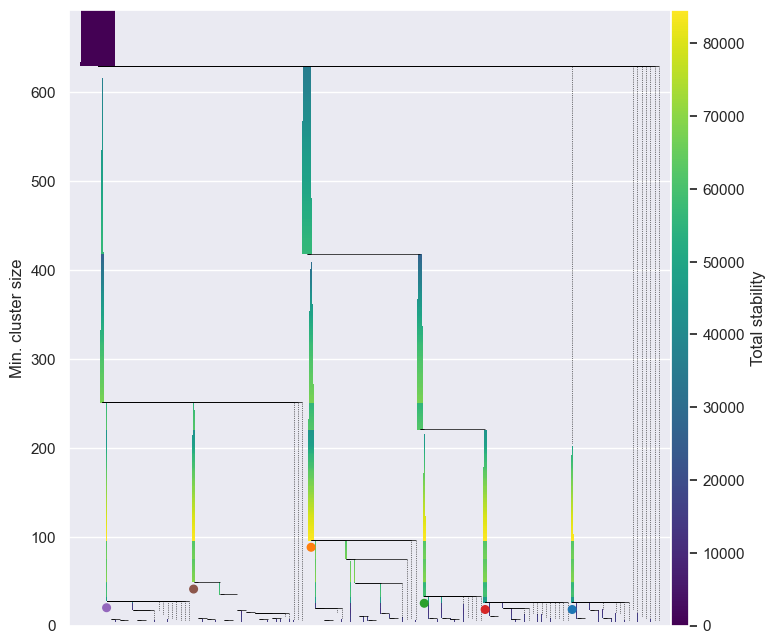

In [14]:
from fast_hdbscan.hdbscan import to_numpy_rec_array

plot_tree = to_numpy_rec_array(condensed_tree)

plt.figure()
tree_class = LeafClusterTree(labels, plot_tree, leaves, total_stability, stabilities)
tree_class.plot(colorbar_kws=dict(pad=0, fraction=0.03))
plt.show()

### EOM-style cluster selection:

EOM-style cluster selection appears less suitable for the leaf-cluster tree.
That approach would always include a segment in all paths below the root. This
includes (potentially) very small and low-stability leaves:

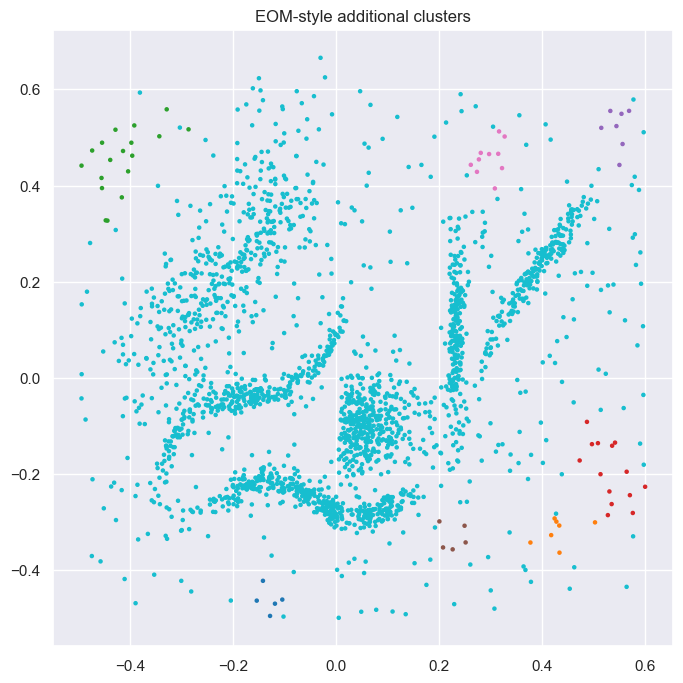

In [15]:
root = condensed_tree.parent[0]
extra_select_leaves = [
    leaf_id
    for leaf_id, parent in tree_class.parents.items()
    if leaf_id != root and parent == root and leaves[leaf_id].death < best_size
]


labels = get_cluster_label_vector(
    condensed_tree,
    extra_select_leaves,
    cluster_selection_epsilon=0.0,
    n_samples=data.shape[0],

)
probs = get_point_membership_strength_vector(condensed_tree, extra_select_leaves, labels)
plt.scatter(*data.T, c=labels % 10, s=5, cmap="tab10", vmax=9, vmin=0)
plt.title(f"EOM-style additional clusters")
plt.show()

### Pruning / simplification

Alternatively, the leaf-cluster tree can be simplified with a minimum stability
threshold. After this pruning, the leaf-cluster tree leaves can be used as
high-stability clusters. This would add an additional parameter though...

## Relation to other cluster selection strategies

HDBSCAN* simplifies single linkage dendrograms using a minimum cluster size to
create a cluster hierarchy (`condensed_tree`). The cluster hierarchy forms a
*merge-tree* listing which connected components exist over all density values.
As density decreases, larger distance edges enter the filtration and create
connections between connected components, merging them in the hierarchy. The
process describes the data's 0-dimensional topology in a filtration over the
density, effectively implementing a *persistent homology* computation.

Clusters are selected from the hierarchy using one of two selection strategies.
The *leaf* strategy always selects the cluster tree's leaves. These clusters
correspond to all local density maxima meeting the size threshold. Effectively,
**this strategy defines clusters as local density maxima**. In practice,
leaf-clusters depend strongly on the minimum cluster size value used to
construct the cluster hierarchy. Many small leaf clusters can be detected for
small minimum cluster sizes, resulting in segmentations where most points are
classified as noise. 

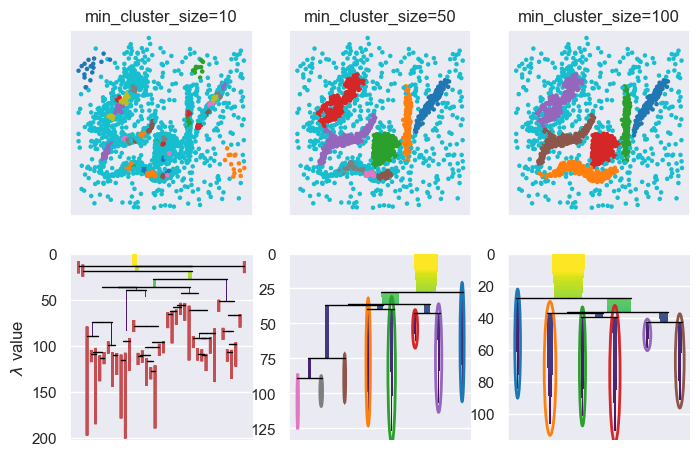

In [16]:
plt.figure(figsize=(8, 8 / 3 * 2))
for i, size in enumerate([10, 50, 100]):
    c = HDBSCAN(
        min_samples=5, min_cluster_size=size, cluster_selection_method="leaf"
    ).fit(data)
    plt.subplot(2, 3, i + 1)
    plt.scatter(
        *data.T,
        c=c.labels_ % 10,
        s=5,
        cmap="tab10",
        vmax=9,
        vmin=0,
    )
    plt.title(f"min_cluster_size={size}")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 3, i + 4)
    c.condensed_tree_.plot(
        select_clusters=True,
        selection_palette=plt.cm.tab10.colors,
        colorbar=False,
    )
    if i > 0:
        plt.ylabel("")

plt.show()

The *EOM* strategy is more statistically motivated. It encourages fewer, larger
clusters by **defining clusters as a neighborhoods with an excess of probability
mass** (explained by Müller & Sawitzki, 1991). In statistical terms, the *EOM*
strategy interprets the density profile as a probability distribution and
computes its *modality*. Specifically, the strategy selects connected components
from the hierarchy that maximize a (relative) stability measure. The stability
measure aggregates the density-ranges in which points are part of a particular
connected component. It combines the number of points contained in the component
with the points' *persistence* in the density filtration. Selecting the most
persistent structures from a filtration as the *true* signal is common in
*persistent homology* and clustering (see, *cluster lifetime* referenced by
Campello et al., 2015). The stability adapts this notion to a cluster with
changing membership over density (Campello et al., 2015). While *EOM* clusters
are less sensitive to the minimum cluster size, the vary enough that the
parameter needs to be tuned to avoid small low-density clusters. Notice that some clusters disappear at larger size thresholds.

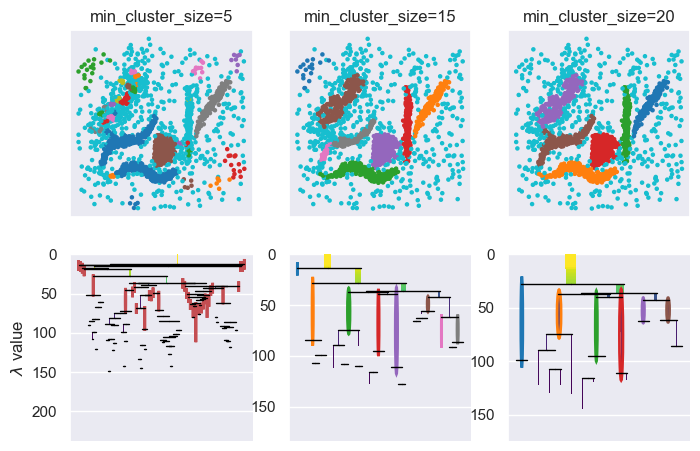

In [17]:
plt.figure(figsize=(8, 8 / 3 * 2))
for i, size in enumerate([5, 15, 20]):
    c = HDBSCAN(min_samples=5, min_cluster_size=size).fit(data)
    plt.subplot(2, 3, i + 1)
    plt.scatter(
        *data.T,
        c=c.labels_ % 10,
        s=5,
        cmap="tab10",
        vmax=9,
        vmin=0,
    )
    plt.title(f"min_cluster_size={size}")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 3, i + 4)
    c.condensed_tree_.plot(
        select_clusters=True,
        selection_palette=plt.cm.tab10.colors,
        colorbar=False,
    )
    if i > 0:
        plt.ylabel("")

plt.show()

Both selection strategies can select clusters with varying densities that do not
correspond to a straight density-cut in the cluster hierarchy. In other words,
there may not be a single distance or density value for which DBSCAN produces
the same clusters.

The strategy demonstrated in this notebook combines the *leaf* and *EOM*
strategies. Where HDBSCAN* computes a cluster tree with all possible DBSCAN
clusters, our strategy creates a cluster tree with HDBSCAN* leaf-clusters over
all possible minimum cluster sizes. It then optimizes the minimum cluster size
parameter to find leaf-clusters with a maximal total stability. The result is
**a (practically) parameter free clustering algorithm that produces *EOM*-like
clusters** and a cluster hierarchy describing leaf-clusters at other size
thresholds. When counting the distance metric as input, only the `min_samples`
parameter remains. This parameter smooths the computed density profile which
prunes low stability leaves from the the leaf-cluster tree. **Changing
`min_samples`** changes the optimal minimum cluster size, but **does not really
change which clusters are selected**. As demonstrated above, this is not true
for the other cluster selection strategies and the minimum cluster size
parameter! At higher `min_samples` the selected clusters becomes smaller, with
more points classified as noise. This suggests low `min_samples` values work
better. However, at too low values (i.e. `min_samples=2` below), the resulting
clusters might to sensitive to local density changes. 

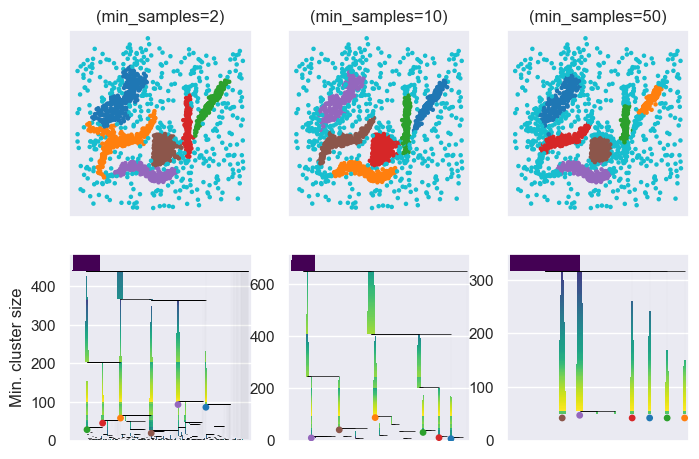

In [18]:
plt.figure(figsize=(8, 8 / 3 * 2))

max_widths = [50, 3, 2]
for i, size in enumerate([2, 10, 50]):
    # Compute initial condensed tree
    minimum_spanning_tree, _, _ = compute_minimum_spanning_tree(data, min_samples=size)
    sorted_mst = minimum_spanning_tree[
        np.lexsort(
            (
                minimum_spanning_tree.T[1],
                minimum_spanning_tree.T[0],
                minimum_spanning_tree.T[2],
            )
        )
    ]
    linkage_tree = mst_to_linkage_tree(sorted_mst)
    condensed_tree = condense_tree(linkage_tree, min_cluster_size=size)

    # Compute optimal leaf-clustering
    leaves = min_cluster_size_barcode(condensed_tree, data.shape[0], size)
    total_stability, stabilities = compute_stabilities(condensed_tree, leaves)
    labels, probs, best_size = optimal_clustering(
        condensed_tree, leaves, total_stability, data.shape[0]
    )

    plt.subplot(2, 3, i + 1)
    plt.scatter(*data.T, c=labels % 10, s=5, cmap="tab10", vmax=9, vmin=0)
    plt.title(f"(min_samples={size})")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 3, i + 4)
    tree_class = LeafClusterTree(
        labels, to_numpy_rec_array(condensed_tree), leaves, total_stability, stabilities
    )
    tree_class.plot(
        colorbar=False,
        max_width=max_widths[i],
        indicator_radius=15,
        death_line_kws=dict(linewidth=0.1, alpha=0.3),
    )
    if i > 0:
        plt.ylabel("")
plt.show()

Benefits:
- Low parameter sensitivity -> easy to use.
- Statistically motivated cluster definition using probability mass.
- Not much more expensive to compute (right?)